In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

In [3]:
df = pd.read_csv('data.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


We'll be dealing with the sales of item 2 from store 5.

In [4]:
new_df = df[df['item'] == 2]
new_df = new_df[new_df['store'] == 5]
new_df

,date,store,item,sales
25564,2013-01-01,5,2,26
25565,2013-01-02,5,2,22
25566,2013-01-03,5,2,26
25567,2013-01-04,5,2,23
25568,2013-01-05,5,2,22
...,...,...,...,...
27385,2017-12-27,5,2,31
27386,2017-12-28,5,2,33
27387,2017-12-29,5,2,42
27388,2017-12-30,5,2,28


Search for missing values

In [5]:
#to check if there are sparsity in the data
new_df.isnull().sum().sum()

0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


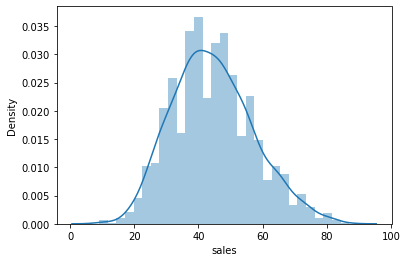

In [6]:
sns.distplot(new_df['sales'])
plt.show()

now for visualizing the sales, yearly , monthly and daywise, new columns need to be added for year, month and day

In [7]:
#new_df['date'] = pd.to_datetime(new_df['date'], format='%Y-%m-%d')

In [8]:
new_df['year'] = pd.DatetimeIndex(new_df['date']).year
new_df['month'] = pd.DatetimeIndex(new_df['date']).month

In [9]:
new_df

,date,store,item,sales,year,month
25564,2013-01-01,5,2,26,2013,1
25565,2013-01-02,5,2,22,2013,1
25566,2013-01-03,5,2,26,2013,1
25567,2013-01-04,5,2,23,2013,1
25568,2013-01-05,5,2,22,2013,1
...,...,...,...,...,...,...
27385,2017-12-27,5,2,31,2017,12
27386,2017-12-28,5,2,33,2017,12
27387,2017-12-29,5,2,42,2017,12
27388,2017-12-30,5,2,28,2017,12


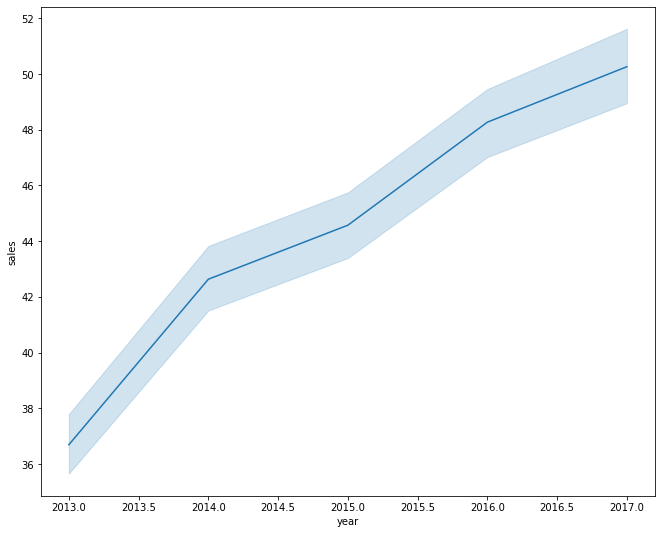

In [10]:
plt.figure(figsize=(11,9))
sns.lineplot(x=new_df['year'], y=new_df['sales'])

In [11]:
#plt.figure(figsize=(11,9))
#sns.lineplot(x=new_df['date'], y=new_df['sales'])

**splitting data into train and test**

In [12]:
#getting index from where data will split
index = new_df.loc[new_df['date'] == '2017-11-01'].index.values[0]
index

27329

In [13]:
train = new_df.loc[:index]
test = new_df.loc[index:]

In [14]:
train1 = train[['date', 'sales']].set_index('date')
test1 = test[['date', 'sales']].set_index('date')

**Holt and winters model**

In [15]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [16]:
model = ExponentialSmoothing(train1 ,trend='add', seasonal='add', seasonal_periods=12)
model_fit = model.fit()
prediction = model_fit.predict(start = test1.index.values[0], end =  test1.index.values[-1])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [17]:
prediction

2017-11-01    46.344735
2017-11-02    46.708513
2017-11-03    46.538184
2017-11-04    47.402922
2017-11-05    46.985093
                ...    
2017-12-27    48.124601
2017-12-28    48.004370
2017-12-29    46.954877
2017-12-30    48.383399
2017-12-31    46.876694
Freq: D, Length: 61, dtype: float64

**Forecast errors for Hots & wintr's model:**

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [19]:
mse = mean_squared_error(test1, prediction)
print("Mean square error for Holt & winter's model is:", mse**0.5)

print('Mean absolute percentage error:',mean_absolute_percentage_error(test1, prediction)*100)

Mean square error for Holt & winter's model is: 12.429995167311366
Mean absolute percentage error: 24.44085437229935


In [20]:
def plots(x,y, prediction, model_name):
  plt.figure(figsize=(9,6))
  plt.plot(x,y, label = 'actual sales')
  plt.plot(x,prediction, label = 'predicted sales')
  plt.legend()
  plt.xlabel('date')
  plt.ylabel('sales')
  plt.title(f'Forecasts using {model_name}')

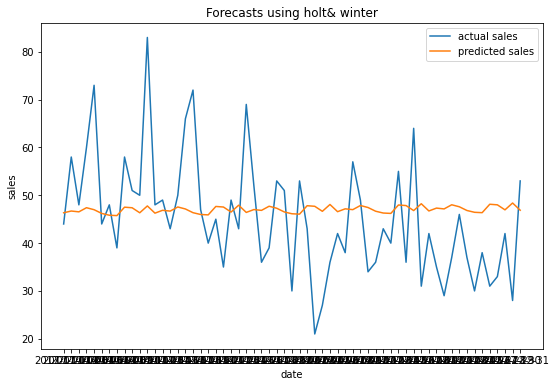

In [21]:
plots(test['date'], test['sales'], prediction, 'holt& winter')

**ARIMA MODEL: Autoregressive Integrated Moving Average **

Step 1: Check for stationarity of data through Dickey Fuller test.

In [22]:
from statsmodels.tsa.stattools import adfuller

#considering 99% confidence
def adFuller(data):
  result = adfuller(data)
  print('Test Statistics:', result[0])
  print('p-value:', result[1])
  for key, value in result[4].items():
    print(f'Critical value ({key}) =', value)
  if result[1]> 0.01:
    print('The data is not stationary')
  if result[1]< 0.01:
    print('The data is stationary')

  


In [23]:
adFuller(train1['sales'])

Test Statistics: -2.952983627848861
p-value: 0.03952456981518131
Critical value (1%) = -3.4341051325206884
Critical value (5%) = -2.8631986817182886
Critical value (10%) = -2.567653033638267
The data is not stationary


From the p-values < 0.05, it can be seen that the data is already stationary, so no need to do differencing to make the data stationary.

test start

In [24]:
first_difference = train1['sales'] - train1['sales'].shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))

In [25]:
adFuller(first_difference['sales'])

Test Statistics: -12.600828957722559
p-value: 1.737760272681713e-23
Critical value (1%) = -3.4341051325206884
Critical value (5%) = -2.8631986817182886
Critical value (10%) = -2.567653033638267
The data is stationary


test end

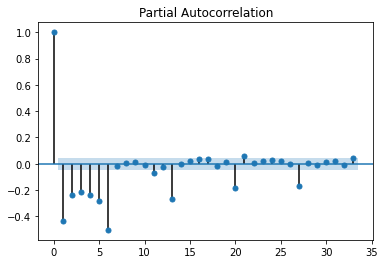

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pacf= plot_pacf(first_difference['sales'])

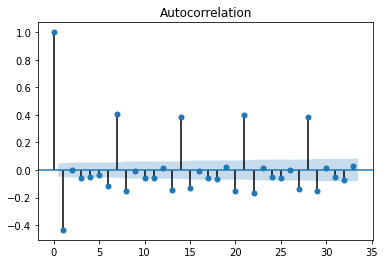

In [27]:
acf=plot_acf(first_difference['sales'])

In [28]:
train1

,sales
date,
2013-01-01,26
2013-01-02,22
2013-01-03,26
2013-01-04,23
2013-01-05,22
...,...
2017-10-28,51
2017-10-29,54
2017-10-30,40


**Applying ARIMA:**

In [29]:
from statsmodels.tsa.arima_model import ARIMA

Arima=ARIMA(train1, order = (6,1,1)).fit(disp=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [30]:
predict = Arima.predict(start = test1.index.values[0], end =  test1.index.values[-1])

In [31]:
sum(predict)

3.810971849469816

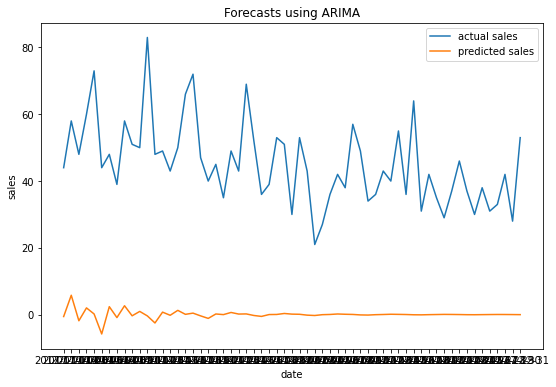

In [32]:
plots(test['date'], test1, predict, 'ARIMA')

In [33]:
mse = mean_squared_error(test1, predict)
print("Mean square error for Holt & winter's model is:", mse**0.5)

print('Mean absolute percentage error:',mean_absolute_percentage_error(test1, predict)*100)

Mean square error for Holt & winter's model is: 46.734179018022424
Mean absolute percentage error: 99.98807665261612


SARIMA

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [35]:
sarima_model = SARIMAX(train1.sales, order=(6, 1, 1), seasonal_order=(6, 1, 1, 7), 
                       enforce_invertibility=False, enforce_stationarity=False)
sarima_fit = sarima_model.fit()
pred = sarima_fit.predict(start=test1.index[0],end=test1.index[-1], dynamic= True)
#plot = sarima_fit.plot_diagnostics(figsize=(14,7))
#plot

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


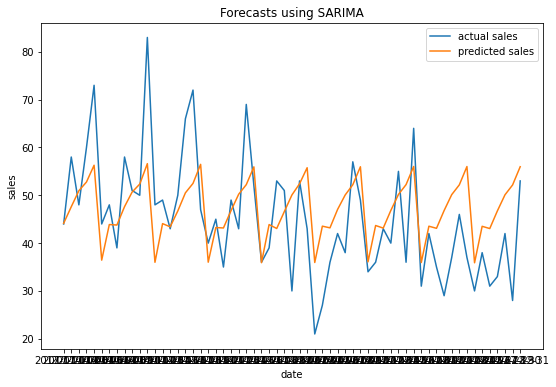

In [36]:
plots(test['date'], test1, pred, 'SARIMA')

In [37]:
mse = mean_squared_error(test1, pred)
print("Mean square error for Holt & winter's model is:", mse**0.5)

print('Mean absolute percentage error:',mean_absolute_percentage_error(test1, pred)*100)

Mean square error for Holt & winter's model is: 10.466746356033486
Mean absolute percentage error: 20.559605130489665


**Linear Regression:**

In [59]:
reg_df = new_df.copy()
reg_df

,date,store,item,sales,year,month
25564,2013-01-01,5,2,26,2013,1
25565,2013-01-02,5,2,22,2013,1
25566,2013-01-03,5,2,26,2013,1
25567,2013-01-04,5,2,23,2013,1
25568,2013-01-05,5,2,22,2013,1
...,...,...,...,...,...,...
27385,2017-12-27,5,2,31,2017,12
27386,2017-12-28,5,2,33,2017,12
27387,2017-12-29,5,2,42,2017,12
27388,2017-12-30,5,2,28,2017,12


In [60]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict the last 2 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2017-11-01']                        
reg_test_df = reg_df.loc['2017-11-01':]

In [61]:
reg_df

,sales,year,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean,rolling_max,rolling_min
date,,,,,,,,,,,,,
2013-01-08,28,2013,1,11.0,28.0,22.0,23.0,26.0,22.0,26.0,22.857143,28.0,11.0
2013-01-09,22,2013,1,28.0,11.0,28.0,22.0,23.0,26.0,22.0,22.857143,28.0,11.0
2013-01-10,32,2013,1,22.0,28.0,11.0,28.0,22.0,23.0,26.0,23.714286,32.0,11.0
2013-01-11,24,2013,1,32.0,22.0,28.0,11.0,28.0,22.0,23.0,23.857143,32.0,11.0
2013-01-12,29,2013,1,24.0,32.0,22.0,28.0,11.0,28.0,22.0,24.857143,32.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-27,31,2017,12,38.0,30.0,37.0,46.0,37.0,29.0,35.0,35.428571,46.0,29.0
2017-12-28,33,2017,12,31.0,38.0,30.0,37.0,46.0,37.0,29.0,36.000000,46.0,30.0
2017-12-29,42,2017,12,33.0,31.0,38.0,30.0,37.0,46.0,37.0,36.714286,46.0,30.0


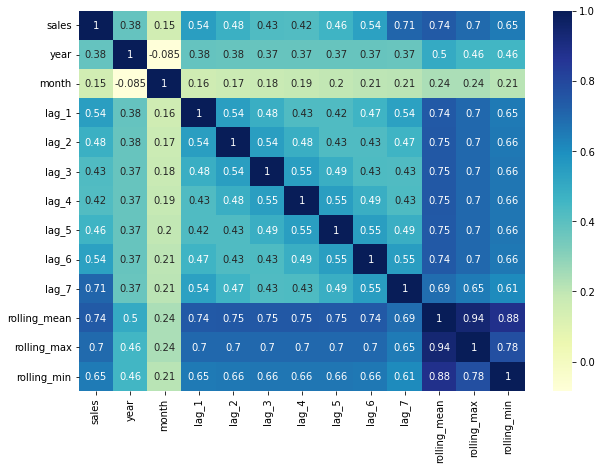

In [89]:
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr,annot=True,cmap="YlGnBu")

In [64]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [65]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

In [70]:
model = LinearRegression()

In [71]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

In [72]:
feature_elimination_svm= RFE(model,n_features_to_select=5,step=1)
svm_binary=feature_elimination_svm.fit(X_train,y_train)
X_train_selected_binary =svm_binary.transform(X_train)
print('shape of selected train data',X_train_selected_binary.shape)
X_test_selected = svm_binary.transform(X_test)

shape of selected train data (1759, 5)


In [73]:
df007=pd.DataFrame(X_train_selected_binary)
df007

,0,1,2,3,4
0,28.0,22.0,26.0,22.0,22.857143
1,11.0,28.0,23.0,26.0,22.857143
2,28.0,11.0,22.0,23.0,23.714286
3,22.0,28.0,28.0,22.0,23.857143
4,32.0,22.0,11.0,28.0,24.857143
...,...,...,...,...,...
1754,53.0,45.0,35.0,47.0,45.714286
1755,47.0,53.0,42.0,35.0,46.714286
1756,51.0,47.0,45.0,42.0,47.428571
1757,54.0,51.0,53.0,45.0,48.142857


In [74]:
model.fit(X_train_selected_binary, y_train)
preds = model.predict(X_test_selected)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [75]:
errors_df

,model,sales,pred_sales,errors
date,,,,
2017-11-01,LinearRegression,44,47.256138,3.256138
2017-11-02,LinearRegression,58,52.994700,-5.005300
2017-11-03,LinearRegression,48,48.930767,0.930767
2017-11-04,LinearRegression,60,52.826867,-7.173133
2017-11-05,LinearRegression,73,58.389357,-14.610643
...,...,...,...,...
2017-12-27,LinearRegression,31,38.125938,7.125938
2017-12-28,LinearRegression,33,33.835727,0.835727
2017-12-29,LinearRegression,42,35.576272,-6.423728


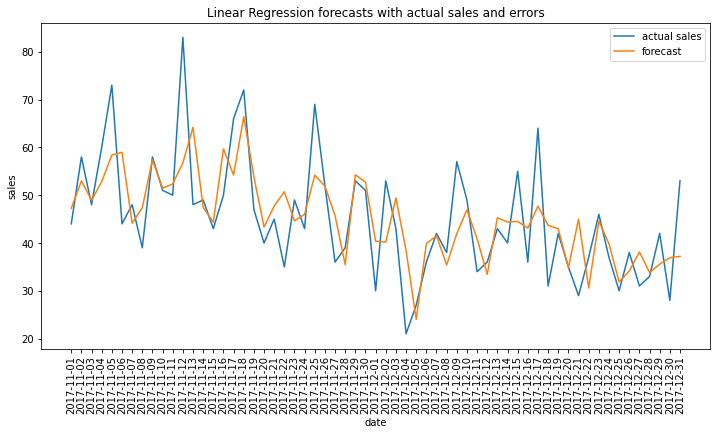

In [86]:
fig = plt.figure(figsize=(12,6))
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend()
plt.xticks(rotation = 90)
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

In [79]:
mse = mean_squared_error(y_test, preds)
print("Mean square error for Linear regression model is:", mse**0.5)

print('Mean absolute percentage error:',mean_absolute_percentage_error(y_test, preds)*100)

Mean square error for Linear regression model is: 8.868316861963383
Mean absolute percentage error: 15.743812414649646


## **$Observation$**
Model is trained on the data of first 10 months and tested on 2 months data. MAPE for holt winter is 24.44%, for SARIMA is 20.55% and regression is 15.74%. New features are *created* using different lags and rolling mean, max and min and amongst them best 5 features are selected using recursive feature elimination technique and the regression model is trained based on those 5 features.